In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('../dataset/train.csv')
X, Y = train.drop('label', axis=1).to_numpy(), train['label'].to_numpy()
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3)
test = pd.read_csv('../dataset/test.csv')
X_test = test.to_numpy()

2


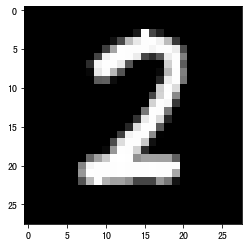

In [3]:
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
print(Y_train[0])

给定数据集$$T={(x_1,y_1), (x_2,y_2),\cdots,(x_N,y_N)}$$
其中$x_i \in \mathbb{R}^n$，$y_i \in \{c_1, c_2, \cdots, c_K\}$

k近邻法通过给定的数据度量方法，在$T$中找到与$x$距离最近的$k$个点，记为$N_k(x)$，则$$y=\mathop{\arg\max}_{c_j} \sum\limits_{x_i \in N_k(x)}I(y_i=c_j)$$

k近邻法的实现主要依赖于快速的寻找距离节点最近的k个点，采用的方法通常为kd-tree，kd-tree主要分为构造kd树和在kd树上进行查找两部分
- 构造
1. 构造kd树根节点，根节点对应于整个超矩形区域
2. 选择一维，并选择该维的一个分割点，从而确定一个超平面将所有的数据点分为左右两个部分
3. 对分割的两个超矩形递归的执行2中的操作，直到每个区域只剩一个节点
第2步中的选择维度主要有两种方法，一种方法是循环的进行切割，每次选择的维度为$depth%dim$，类似于切割豆腐，但是假设我们的数据分布类似于木棒，一般来讲我们会在长的方向连续多切割几次，这种情况可以采用对每一维计算方差，选择方差最大的维度进行切割，也就是分布较长的。

- 查找
1. 自根节点开始，假设要查找点在该节点的左子树对应的超矩形区域，则进入左子树进行查找，否则进入右子树
2. 若当前节点对应的另一侧区域可能存在比当前已知最近点更近的区域，则进入另一侧查找。具体的，判断另一侧区域是否可能存在更近的节点可以通过判断查询节点距离当前分割线的距离与查询节点距离已知最近点的距离的大小关系判定

In [4]:
class KDTreeNode:
    def __init__(self, data, label, split_dim, parent=None, left=None, right=None):
        self.data = data
        self.label = label
        self.split_dim = split_dim
        self.left = left
        self.right = right

class KHeap:
    def __init__(self, k):
        self.k = k
        self.data = []
        for i in range(k):
            self.data.append((-1, -1))
    
    def push(self, dist, label):
        for i in range(self.k):
            if (self.data[i][0] > dist) or (self.data[i][0] == -1):
                self.data.insert(i, (dist, label))
                break
        self.data = self.data[:self.k]
    
    def max_dist(self):
        return self.data[-1][0]
    
    def gen_label(self):
        labels = [x[1] for x in self.data]
        return max(labels, key=labels.count)

def build_KDTree(X, Y, depth=0):
    if len(X) == 0:
        return None
    dim = len(X[0])
    split_dim = depth % dim
    indices = np.argsort(X[:, split_dim])
    X = X[indices]
    Y = Y[indices]
    index = len(X) // 2
    left = build_KDTree(X[:index], Y[:index], depth+1)
    right = build_KDTree(X[index+1:], Y[index+1:], depth+1)
    node = KDTreeNode(data=X[index], label=Y[index], split_dim=split_dim, left=left, right=right)
    return node

def search_KDTree(node, p, heap):
    if node is None:
        return 
    
    dist = np.sum([(a - b) ** 2 for a, b in zip(node.data, p)])
    heap.push(dist, node.label)
    
    dim = node.split_dim
    if p[dim] <= node.data[dim]:
        nxt = node.left
        oppo = node.right
    else:
        nxt = node.right
        oppo = node.left
    
    search_KDTree(nxt, p, heap)
    
    if ((p[dim] - node.data[dim]) * (p[dim] - node.data[dim]) < heap.max_dist()) or (heap.max_dist() == -1):
        search_KDTree(oppo, p, heap)
        
class KNearestNeighbors:
    def __init__(self, kneighbors=5):
        self.kneighbors = kneighbors
        self.root = None
    
    def fit(self, X, Y):
        X = np.array(X)
        Y = np.array(Y)
        self.root = build_KDTree(X, Y)
    
    def predict(self, X):
        Y = []
        for x in X:
            heap = KHeap(self.kneighbors)
            search_KDTree(self.root, x, heap)
            Y.append(heap.gen_label())
        return Y

In [5]:
model = KNearestNeighbors(kneighbors=5)
model.fit(X_train, Y_train)
model.predict(X_val[:10])

[0, 4, 3, 4, 2, 8, 7, 9, 1, 1]

# sklearn

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [7]:
model = KNeighborsClassifier(algorithm='kd_tree')
model.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [8]:
Y_pred = model.predict(X_val)
accuracy_score(Y_val, Y_pred)

0.9650793650793651